In [1]:
!pip install torch
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
!pip install imageio==2.4.1
!pip install moviepy
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 43.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 36.1 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=5f982c2aae0c3df5773ce2cb0b3506a59343295c2dab2e6c5b14a0dfdc4eeb1f
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os, subprocess
from random import randint
import numpy as np
from PIL import Image, ImageDraw, ImageFont

import librosa
import moviepy.editor as mp
import cv2

import torch
import torch.nn as nn
import torchvision.transforms as transforms

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4128768/45929032 bytes (9.0%)8339456/45929032 bytes (18.2%)12550144/45929032 bytes (27.3%)16490496/45929032 bytes (35.9%)20676608/45929032 bytes (45.0%)24666112/45929032 bytes (53.7%)28827648/45929032 bytes (62.8%)32915456/45929032 bytes (71.7%)37158912/45929032 bytes (80.9%)41385984/45929032 bytes (90.1%)45596672/45929032 bytes (99.3%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_size = (299, 299)
classes = ["carrying", "normal", "threat"]

In [5]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

root_path = "/content/drive/MyDrive/NUS/CS4243/CS4243_mini_project"
model_root_path = os.path.join(root_path, "models")
ensemble_demo_path = os.path.join(root_path, "ensemble_demo")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_model_name = "inception_ensemble_image_classifier_lr3_e20_elr7"
spec_model_name = "inception_ensemble_spectrogram_classifier_lr3_e20_elr9"

  "You are about to download and run code from an untrusted repository. In a future release, this won't "

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-11-3 Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [6]:
def create_model(num_classes: int = 3, model_path = None):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=model_path is None)
    model.AuxLogits.fc = nn.Linear(768, num_classes)
    model.fc = nn.Linear(2048, num_classes)
    if model_path:
        model.load_state_dict(torch.load(model_path))
    return model.to(device)

In [7]:
image_model = create_model(model_path=os.path.join(model_root_path, image_model_name))
image_model.eval()
spec_model = create_model(model_path=os.path.join(model_root_path, spec_model_name))
spec_model.eval()
print("Models loaded!")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights

Models loaded!


In [8]:
input_shape = (299, 299)

# Image transformations
img_transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

spec_transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
# crop by expanding bounding box by 10% of image size
crop_expansion_factor = 0.1

def get_person_bounding_boxes(img):
    result = yolo(img)
    detection = result.pandas().xyxy[0]
    bounding_boxes = []

    width, height = img.size

    if "person" in detection.name.values:
        rows = detection[detection.name == "person"]

        for _, row in rows.iterrows():
          ymin = max(0, int(row.ymin - height * crop_expansion_factor)) 
          ymax = min(height, int(row.ymax + height * crop_expansion_factor))
          xmin = max(0, int(row.xmin - width * crop_expansion_factor))
          xmax = min(width, int(row.xmax + width * crop_expansion_factor))

          bounding_boxes.append({'xmin': xmin, 'xmax': xmax, 'ymin': ymin, 'ymax': ymax})

    if not bounding_boxes:
        bounding_boxes.append({'xmin': 0, 'xmax': width, 'ymin': 0, 'ymax': height})

    return bounding_boxes

In [10]:
def has_audio(file_path):
    result = subprocess.run(
        [
            "ffprobe", 
            "-v", 
            "error", 
            "-show_entries", 
            "format=nb_streams", 
            "-of", 
            "default=noprint_wrappers=1:nokey=1", 
            file_path,
        ],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )
    try:
        return int(result.stdout.strip()) > 1
    except:
        return False

def extract_audio(video_name, video_path):
    try:
        video_data = mp.VideoFileClip(video_path)
        file_name, _, _ = video_name.rpartition(".")
        if video_data.audio:
            audio_name = f"{file_name}_audio.mp3"
            video_data.audio.write_audiofile(os.path.join(ensemble_demo_path, audio_name))
            return os.path.join(ensemble_demo_path, audio_name)
    except:
        ...


def get_melspectrogram_db(file_path, sr = None, n_fft = 2048, hop_length = 512, n_mels = 128, fmin = 20, fmax = 8300, top_db = 80):
    wav, sr = librosa.load(file_path, sr=sr)
    if wav.shape[0] < 5 * sr:
        wav = np.pad(wav, int(np.ceil((5 * sr - wav.shape[0]) / 2)), mode="reflect")
    else:
        wav = wav[:5*sr]
    spec = librosa.feature.melspectrogram(
        wav,
        sr=sr, 
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax
    )
    spec_db = librosa.power_to_db(spec, top_db=top_db)
    return spec_db


def get_spectrogram_image(file_path):
    spec = get_melspectrogram_db(file_path)
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + 1e-6)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    return spec_scaled


def convert_spectrograms(audio_path):
    spec_img = get_spectrogram_image(audio_path)
    return spec_img


def get_spectrogram(video_name, video_path):
    if has_audio(video_path):
        print("Processing Audio...")
        audio_path = extract_audio(video_name, video_path)

        print("Processing Spectrograms...")
        return convert_spectrograms(audio_path)
    else:
        print("Video doesn't have audio")
        return np.zeros(input_shape)

In [53]:
def extract_random_frame(video_path):
    vidcap = cv2.VideoCapture(video_path)
    num_of_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    res = False
    frame_to_read = 0
    frame = []
    while not res:
        frame_to_read = randint(0, num_of_frames - 1)
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_read)
        res, frame = vidcap.read()
    print(f"=================\nRandomly chose frame {frame_to_read} from video")
    return frame

In [54]:
image_weight = 0.93
spec_weight = 0.57

def get_classification(img, spec):
    transformed_img = img_transform(img).unsqueeze(0).to(device)
    transformed_spec = spec_transform(spec).unsqueeze(0).to(device)

    img_logit = image_model(transformed_img)
    spec_logit = spec_model(transformed_spec)
    spec_mask = int(np.array(spec).any())
    masked_spec = torch.transpose(spec_mask * torch.transpose(spec_logit, 0, 1), 0, 1)

    logit = (img_logit * image_weight + masked_spec  * spec_weight) / (image_weight + spec_weight)

    return torch.max(logit, dim=1)[1].item()

In [59]:
video_name = "A0222462N_20220831_threat_0007.mp4" # threat, with sound
# video_name = "A0261367B_20220902_threat_4024.mp4" # thread, no sound

video_path = os.path.join(ensemble_demo_path, video_name)

extracted_spectrogram = get_spectrogram(video_name, video_path)
extracted_frame = extract_random_frame(video_path)

Processing Audio...
[MoviePy] Writing audio in /content/drive/MyDrive/NUS/CS4243/CS4243_mini_project/ensemble_demo/A0222462N_20220831_threat_0007_audio.mp3


100%|██████████| 316/316 [00:00<00:00, 925.47it/s]

[MoviePy] Done.



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



Processing Spectrograms...
Randomly chose frame 79 from video


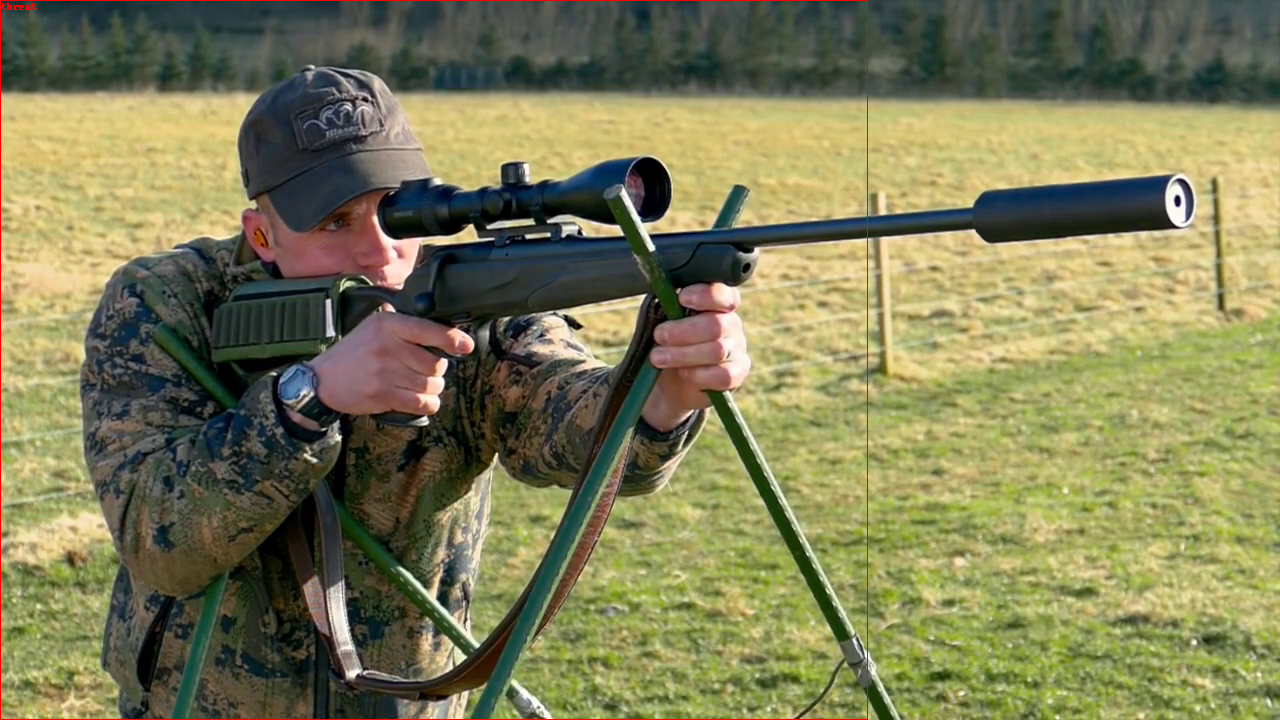

In [60]:
try:
  frame_img = Image.fromarray(extracted_frame[: , :, ::-1])
except Exception as e:
  print('Warning: Failed to parse image')
  print('Error: %s' %e)
  raise

try:
  frame_pil = frame_img.convert('RGB')
except:
  print('Warning: Failed to format image')
  raise

try:
  spec_img = Image.fromarray(extracted_spectrogram)
except Exception as e:
  print('Warning: Failed to parse image')
  print('Error: %s' %e)
  raise

try:
  spec_pil = spec_img.convert('RGB')
except:
  print('Warning: Failed to format image')
  raise

bounding_boxes = get_person_bounding_boxes(frame_pil)

img_to_annotate = frame_pil.copy()
draw = ImageDraw.Draw(img_to_annotate)
annotating_color = 'red'

for bounding_box in bounding_boxes:
    xmin = bounding_box['xmin']
    xmax = bounding_box['xmax']
    ymin = bounding_box['ymin']
    ymax = bounding_box['ymax']

    pred = get_classification(frame_pil.crop((xmin, ymin, xmax, ymax)), spec_pil)

    draw.rectangle([(xmin, ymin), (xmax - 1, ymax - 1)], outline=annotating_color)
    draw.text((xmin + 1, ymin + 1), classes[pred], fill=annotating_color)

img_to_annotate